In [1]:
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools

# Utility functions

## Open dicom folder

In [2]:
def read_dicomdir(dir_path: str) -> list:
    # opening the dicom files in the dir
    dicom_files = [
        os.path.join(dir_path, f) 
        for f in os.listdir(dir_path)
    ]
    
    # Sort the files based on slice location (for this patient is already done)
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)
    
    # read the actual dicom files
    slices = [pydicom.dcmread(f) for f in dicom_files]
    
    return slices

## Reconstruct 3d shape

In [3]:
def get_3d_shape(dicom_slices: list) -> np.ndarray:
    pixel_arrays = [s.pixel_array for s in dicom_slices]

    # stack the slices to create a 3d array
    volume_3d = np.stack(pixel_arrays, axis=0)
    
    # flip the dicom on the vertical axis
    return volume_3d[:, ::-1, :]

## Read the Multiphase MRI

In [4]:
def get_multiphase_mri(dir_path: str) -> tuple:
    volume = get_3d_shape(read_dicomdir(dir_path))
    l = np.array_split(volume, 5, axis=0)
    return (*l,)

## Get number of bins for an histogram

To choose the number of bins the Freedman Diaconis rule is used
https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram

In [5]:
def get_n_bins(array: np.ndarray) -> int:
    q75, q25 = np.percentile(array, [75, 25])
    iqr = q75 - q25

    bin_width = 2 * iqr * pow(np.size(array), -1/3)
    return int((np.max(array) - np.min(array))/bin_width)

# Registered Ax T2 FSE

In [6]:
df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)
df.head()

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...


### Patient AMBL-001

#### Analysis on all the volume

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("AMBL-001")

volume = get_3d_shape(read_dicomdir(df.at[0, "Registered Ax T2 FSE path"]))
frq, edges = np.histogram(
    volume, 
    get_n_bins(volume))

ax[0].bar(edges[:-1], frq, width=np.diff(edges), edgecolor="blue", align="edge")
ax[0].axvline(x=np.median(volume.flatten()), color = "k")
ax[0].set_yscale("log")
ax[0].set_title("Without Robust Scaling")

volume = np.load(df.at[0, "RobustScaled Registered Ax T2 FSE path"])
frq, edges = np.histogram(
    volume, 
    get_n_bins(volume))

ax[1].bar(edges[:-1], frq, width=np.diff(edges), edgecolor="blue", align="edge")
ax[1].axvline(x=np.median(volume.flatten()), color = "k")
ax[1].set_yscale("log")
ax[1].set_title("With Robust Scaling")

plt.show()

### Benign/Tumor classes

In [11]:
tumor_df = df[df["tumor/benign"] == 1]
benign_df = df[df["tumor/benign"] == 0]

In [12]:
tumor_df.head(1)

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...


In [28]:
tumor_values = []
benign_values = []

for _, row in tumor_df.iterrows():
    volume = np.load(row["RobustScaled Registered Ax T2 FSE path"])
    roi = np.load(row["Cleaned Roi mask Filepath"])

    for _ in volume[ roi == 1 ]:
        tumor_values.append(_)

for _, row in benign_df.iterrows():
    volume = np.load(row["RobustScaled Registered Ax T2 FSE path"])
    roi = np.load(row["Cleaned Roi mask Filepath"])

    for _ in volume[ roi == 1 ]:
        benign_values.append(_)

In [29]:
pd.DataFrame(
    [
        [np.mean(benign_values), np.median(benign_values), np.std(benign_values)],
        [np.mean(tumor_values), np.median(tumor_values), np.std(tumor_values)]
    ],
    index = ["Benign", "Tumor"],
    columns= ["Mean", "Median", "Std"]
)

,Mean,Median,Std
Benign,3.309619,2.920455,1.808867
Tumor,3.978471,3.539683,2.358411


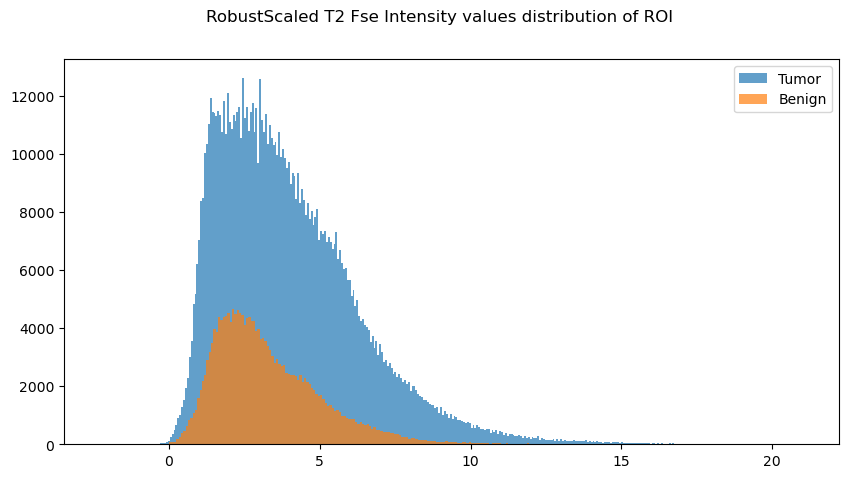

In [33]:
plt.figure(figsize=(10, 5))
plt.suptitle("RobustScaled T2 Fse Intensity values distribution of ROI")

plt.hist(tumor_values, bins=get_n_bins(tumor_values), label="Tumor", alpha = 0.7)
plt.hist(benign_values, bins=get_n_bins(benign_values), label="Benign", alpha = 0.7)
plt.legend(loc='upper right')

# Display the plot
plt.savefig("/media/bendico765/Crucial X9/MRI Lesions/figures/RobustScaledT2Distribution")

### Representative subjects

In [7]:
benign_sample_df = df[df["tumor/benign"] == 0].sample(3)
tumor_sample_df = df[df["tumor/benign"] == 1].sample(3)

In [8]:
benign_sample_df

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path
781,AMBL-563,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,7.04,R,"[59, 60]","[204, 205, 206, 207, 208, 209, 210, 211, 212, ...","[361, 362, 363, 364, 365, 366, 367, 368, 369]",2,10,9,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
138,AMBL-024,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-49.10,R,"[77, 78, 79, 80, 81, 82, 83, 84, 85, 86]","[183, 184, 185, 186, 187, 188, 189, 190, 191, ...","[362, 363, 364, 365, 366, 367, 368, 369, 370, ...",10,56,31,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6055,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1039,AMBL-606,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,27.49,L,"[53, 54, 55]","[126, 127, 128, 129, 130, 131, 132, 133, 134, ...","[116, 117, 118, 119]",3,13,4,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...


In [16]:
pd.concat([
    benign_sample_df[["Patient ID", "Registered Ax T2 FSE path", "RobustScaled Registered Ax T2 FSE path"]],
    tumor_sample_df[["Patient ID", "Registered Ax T2 FSE path", "RobustScaled Registered Ax T2 FSE path"]]
    ]
)

,Patient ID,Registered Ax T2 FSE path,RobustScaled Registered Ax T2 FSE path
781,AMBL-563,/media/bendico765/Crucial X9/MRI Lesions/manif...,/media/bendico765/Crucial X9/MRI Lesions/Robus...
138,AMBL-024,/media/bendico765/Crucial X9/MRI Lesions/manif...,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1039,AMBL-606,/media/bendico765/Crucial X9/MRI Lesions/manif...,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1110,AMBL-618,/media/bendico765/Crucial X9/MRI Lesions/manif...,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1,AMBL-001,/media/bendico765/Crucial X9/MRI Lesions/manif...,/media/bendico765/Crucial X9/MRI Lesions/Robus...
810,AMBL-568,/media/bendico765/Crucial X9/MRI Lesions/manif...,/media/bendico765/Crucial X9/MRI Lesions/Robus...


In [25]:
n_bins = 10

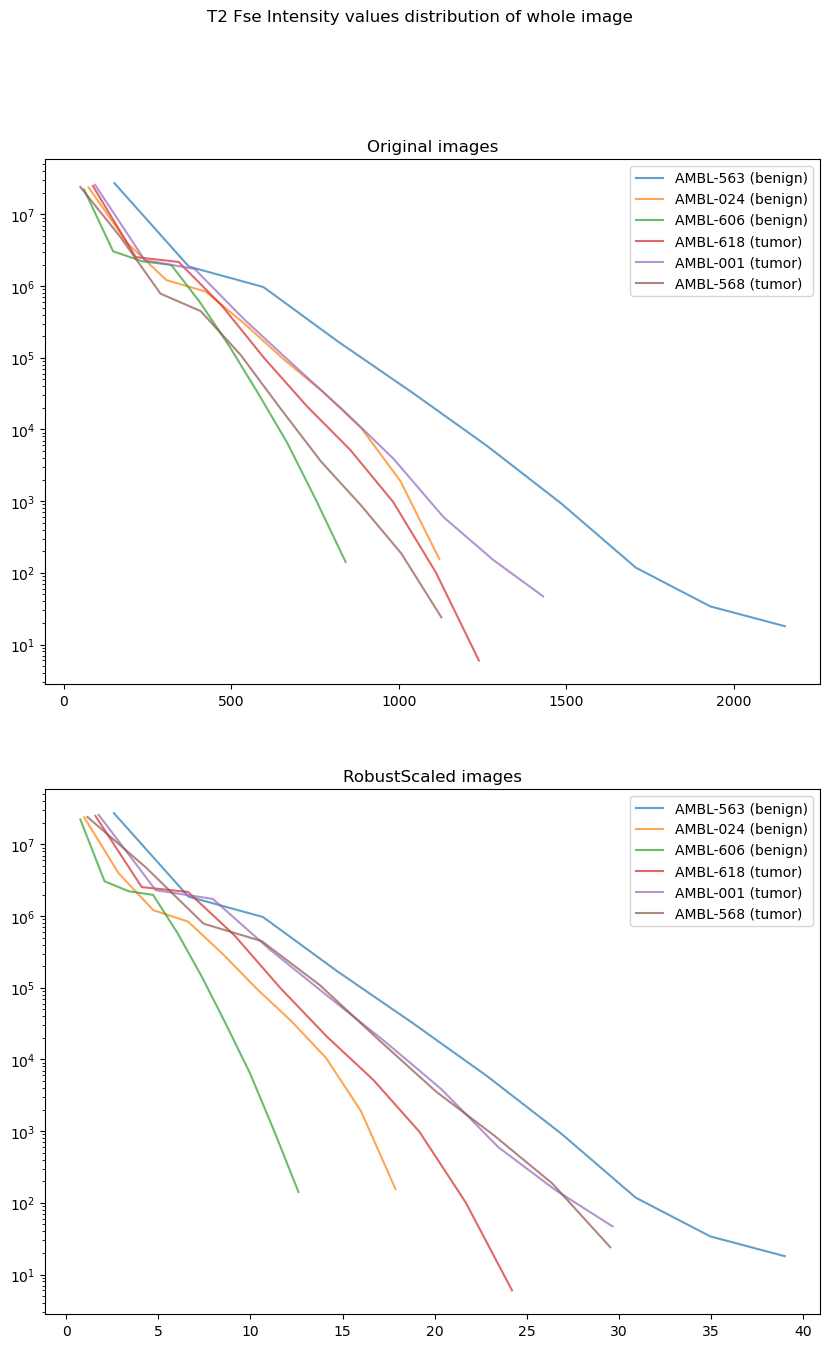

In [31]:
fig, axes = plt.subplots(2,1, figsize=(10,15), sharey=True)
plt.suptitle("T2 Fse Intensity values distribution of whole image")
plt.yscale("log")

for _, row in pd.concat([benign_sample_df, tumor_sample_df]).iterrows():
    patient_id = row["Patient ID"]
    label = row["tumor/benign"]
    volume = get_3d_shape(read_dicomdir(row["Registered Ax T2 FSE path"]))
    scaled_volume = np.load(row["RobustScaled Registered Ax T2 FSE path"])

    intesity_array = np.array(
        [
            _ for _ in volume.flatten()
        ],
        dtype="int16"
    )

    heights, edges = np.histogram(intesity_array, n_bins)
    edges = edges[:-1]+(edges[1]-edges[0])
    axes[0].plot(
        edges, 
        heights, 
        alpha = 0.7, 
        label = f"{patient_id} ({'benign' if label == 0 else 'tumor'})"
    )
    
    scaled_intensity_array = np.array(
        [
            _ for _ in scaled_volume.flatten()
        ],
        dtype="float64"
    )
    heights, edges = np.histogram(scaled_intensity_array, n_bins)
    edges = edges[:-1]+(edges[1]-edges[0])
    axes[1].plot(
        edges, 
        heights, 
        alpha = 0.7, 
        label = f"{patient_id} ({'benign' if label == 0 else 'tumor'})"
    )

axes[0].set_title("Original images")
axes[0].legend(loc='upper right')

axes[1].set_title("RobustScaled images")
axes[1].legend(loc='upper right')

plt.savefig("/media/bendico765/Crucial X9/MRI Lesions/figures/RobustScaledT2Distribution")

In [15]:
benign_values = np.array(
    [
    intensity_value
    for _, row in benign_sample_df.iterrows() for intensity_value in get_3d_shape(read_dicomdir(row["Registered Ax T2 FSE path"])).flatten()
    ],
    dtype="int16"
)

tumor_values = np.array(
    [
    intensity_value
    for _, row in tumor_sample_df.iterrows() for intensity_value in get_3d_shape(read_dicomdir(row["Registered Ax T2 FSE path"])).flatten()
    ],
    dtype="int16"
)

scaled_benign_values = np.array(
    [
    intensity_value
    for _, row in benign_sample_df.iterrows() for intensity_value in np.load(row["RobustScaled Registered Ax T2 FSE path"]).flatten()
    ],
    dtype="float64"
)

scaled_tumor_values = np.array(
    [
    intensity_value
    for _, row in tumor_sample_df.iterrows() for intensity_value in np.load(row["RobustScaled Registered Ax T2 FSE path"]).flatten()
    ],
    dtype="float64"
)

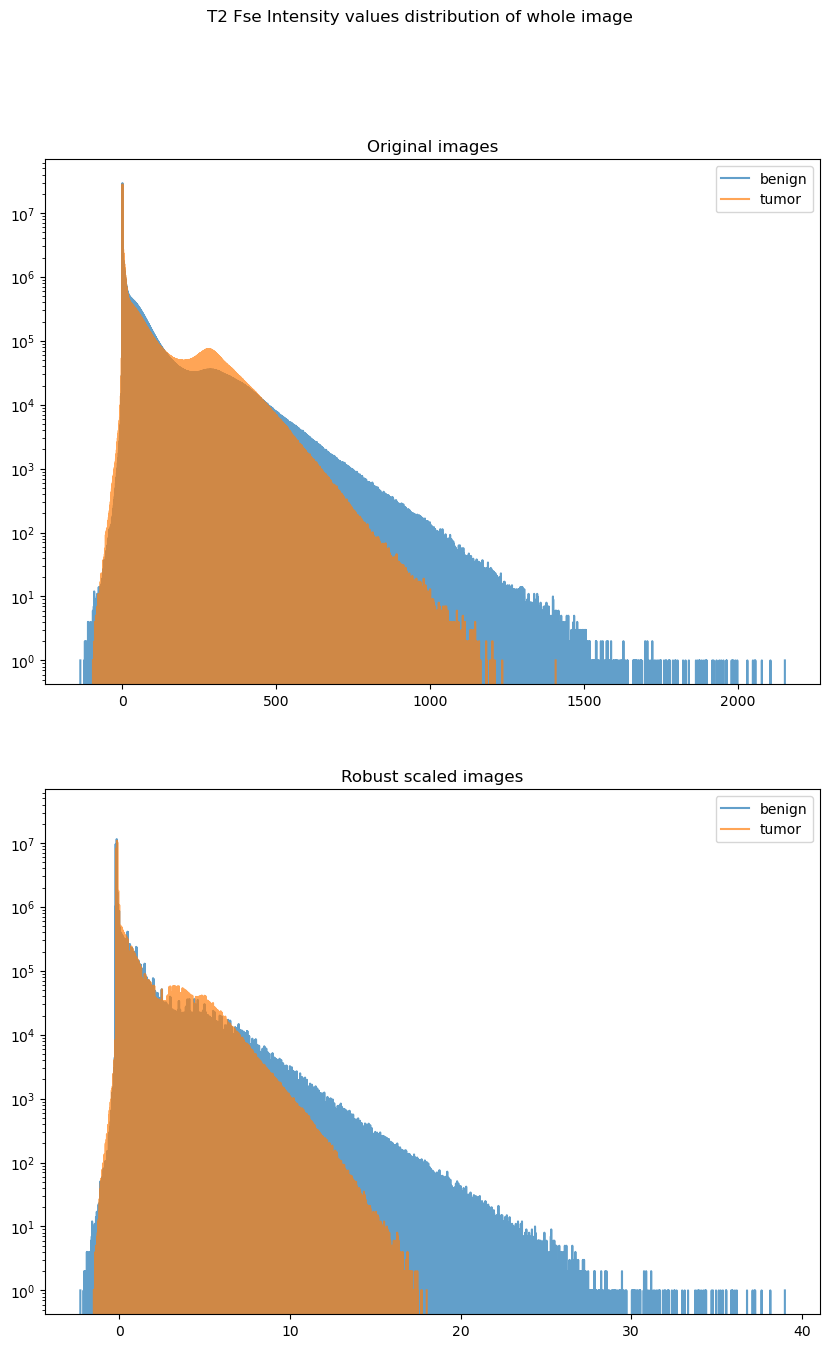

In [21]:
fig, axes = plt.subplots(2,1, figsize=(10,15), sharey=True)
plt.suptitle("T2 Fse Intensity values distribution of whole image")
plt.yscale("log")

heights, edges = np.histogram(benign_values, get_n_bins(benign_values))
edges = edges[:-1]+(edges[1]-edges[0])
axes[0].plot(edges, heights, alpha = 0.7, label = "benign")

heights, edges = np.histogram(tumor_values, get_n_bins(tumor_values))
edges = edges[:-1]+(edges[1]-edges[0])
axes[0].plot(edges, heights, alpha = 0.7, label = "tumor")

axes[0].set_title("Original images")
axes[0].legend(loc='upper right')

heights, edges = np.histogram(scaled_benign_values, get_n_bins(scaled_benign_values))
edges = edges[:-1]+(edges[1]-edges[0])
axes[1].plot(edges, heights, alpha = 0.7, label = "benign")

heights, edges = np.histogram(scaled_tumor_values, get_n_bins(scaled_tumor_values))
edges = edges[:-1]+(edges[1]-edges[0])
axes[1].plot(edges, heights, alpha = 0.7, label = "tumor")

axes[1].set_title("Robust scaled images")
axes[1].legend(loc='upper right')

# Display the plot
plt.savefig("/media/bendico765/Crucial X9/MRI Lesions/figures/RobustScaledT2Distribution")

# Multiphase

In [6]:
df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)
df.head()

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...


## Assign Registered AX Sen Vibrant MultiPhase to each patient

In [12]:
df.head(1)

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...


In [13]:
df["Registered AX Sen Vibrant MultiPhase path"] = [
    [roots for roots, dirs, files in os.walk("/".join(row["Registered Ax T2 FSE path"].split("/")[:-1])) if "Registered AX Sen Vibrant MultiPhase" in roots][0]
    for _, row in df.iterrows()
]

In [14]:
df.head(1)

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path,Registered AX Sen Vibrant MultiPhase path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...


## Patient AMBL-001

In [15]:
dicom_path = "/media/bendico765/Crucial X9/MRI Lesions/manifest-1728494830954/Advanced-MRI-Breast-Lesions/AMBL-001/03-05-2004-NA-MRI BREASTS - Delayed contrast-93547/500.000000-Registered AX Sen Vibrant MultiPhase-85715"
v1, v2, v3, v4, v5 = get_multiphase_mri(dicom_path)

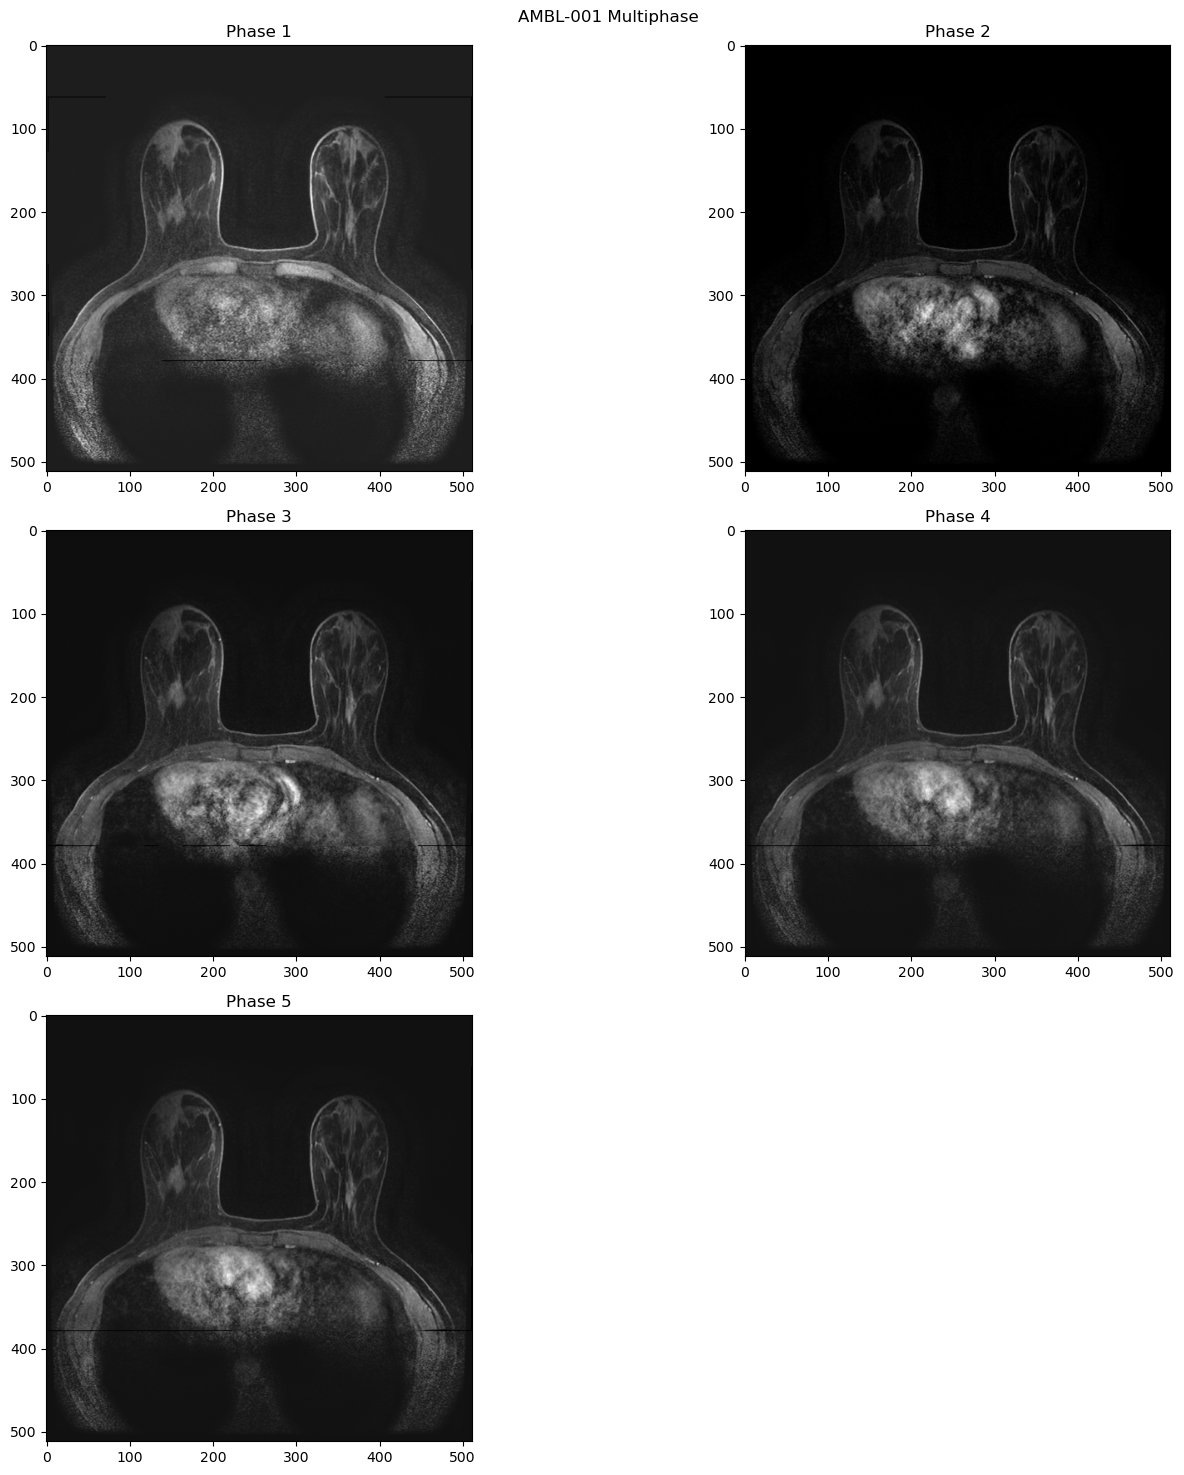

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle("AMBL-001 Multiphase")

# First subplot
axes[0,0].imshow(v1[83, :, :], cmap=plt.cm.gray)
axes[0,0].set_title('Phase 1')

# First subplot
axes[0,1].imshow(v2[83, :, :], cmap=plt.cm.gray)
axes[0,1].set_title('Phase 2')

# First subplot
axes[1,0].imshow(v3[83, :, :], cmap=plt.cm.gray)
axes[1,0].set_title('Phase 3')

# First subplot
axes[1,1].imshow(v4[83, :, :], cmap=plt.cm.gray)
axes[1,1].set_title('Phase 4')

# First subplot
axes[2,0].imshow(v4[83, :, :], cmap=plt.cm.gray)
axes[2,0].set_title('Phase 5')

fig.delaxes(axes[2,1])

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

### Histogram of intensity values

#### Whole solid

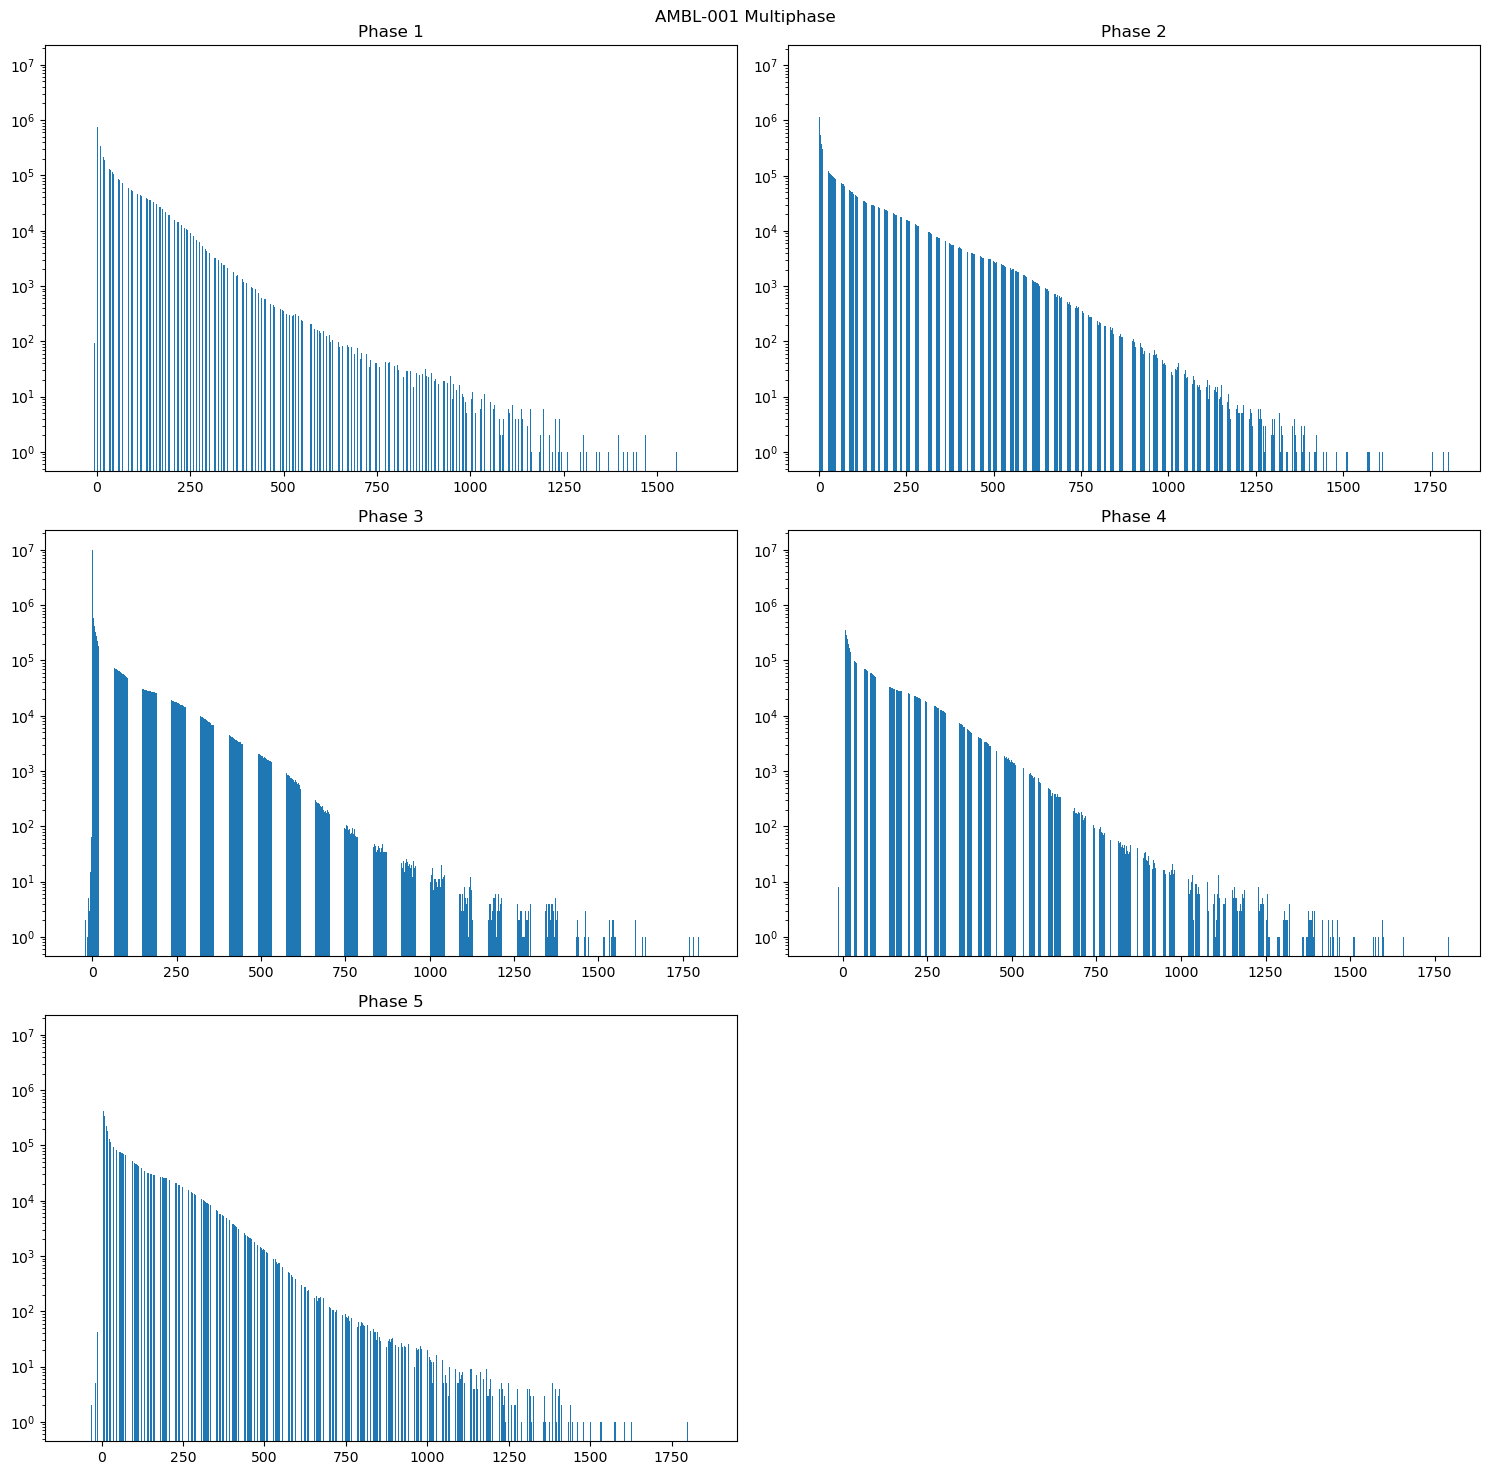

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle("AMBL-001 Multiphase")

# First subplot
axes[0,0].hist(v1.flatten(), bins=get_n_bins(v1))
axes[0,0].set_yscale("log")
axes[0,0].set_title('Phase 1')

# First subplot
axes[0,1].hist(v2.flatten(), bins=get_n_bins(v2))
axes[0,1].set_yscale("log")
axes[0,1].set_title('Phase 2')

# First subplot
axes[1,0].hist(v3.flatten(), bins=get_n_bins(v3))
axes[1,0].set_yscale("log")
axes[1,0].set_title('Phase 3')

# First subplot
axes[1,1].hist(v4.flatten(), bins=get_n_bins(v4))
axes[1,1].set_yscale("log")
axes[1,1].set_title('Phase 4')

# First subplot
axes[2,0].hist(v5.flatten(), bins=get_n_bins(v5))
axes[2,0].set_yscale("log")
axes[2,0].set_title('Phase 5')

fig.delaxes(axes[2,1])

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

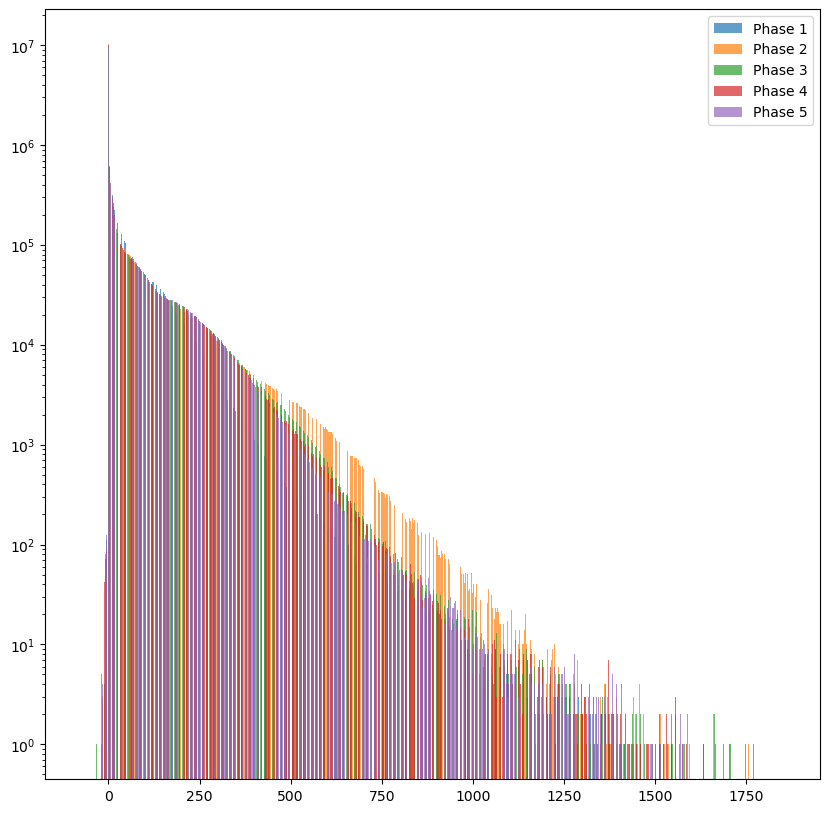

In [18]:
plt.figure(figsize=(10, 10))

#axes[0,0].imshow(v1[83, :, :], cmap=plt.cm.gray)
plt.hist(v1.flatten(), bins=get_n_bins(v1), label="Phase 1", alpha = 0.7)
plt.hist(v2.flatten(), bins=get_n_bins(v2), label="Phase 2", alpha = 0.7)
plt.hist(v3.flatten(), bins=get_n_bins(v3), label="Phase 3", alpha = 0.7)
plt.hist(v4.flatten(), bins=get_n_bins(v4), label="Phase 4", alpha = 0.7)
plt.hist(v5.flatten(), bins=get_n_bins(v5), label="Phase 5", alpha = 0.7)
plt.yscale("log")
plt.legend(loc='upper right')

# Display the plot
plt.show()

#### Region of interest only

In [19]:
roi = np.load(df.at[0, "Cleaned Roi mask Filepath"])
masked_values = v1[roi == 1]

In [20]:
patient1_df = pd.DataFrame(
    [
        [
            np.mean( v[roi == 1] ),
            np.median( v[roi == 1] ),
            np.std( v[roi == 1] )
        ]
        for v in [v1, v2, v3, v4, v5]
    ],
    index = ["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"],
    columns = ["Mean", "Median", "Std"]
)
patient1_df

,Mean,Median,Std
Phase 1,122.013338,127.0,32.274097
Phase 2,188.637347,191.0,57.439844
Phase 3,216.227469,220.0,56.100022
Phase 4,225.372747,231.0,56.334766
Phase 5,221.295963,230.0,58.829321


Text(0.5, 1.0, 'Standard deviation')

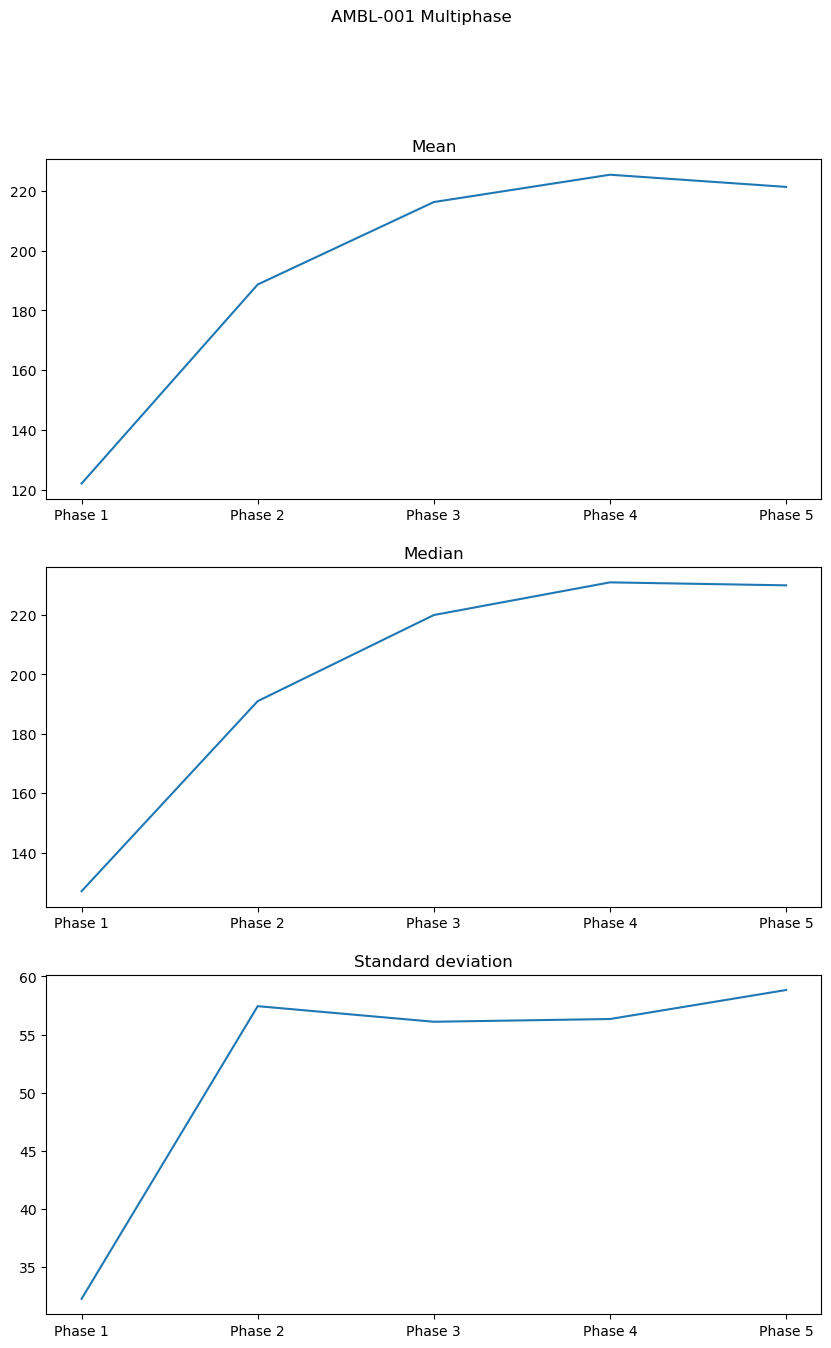

In [21]:
fig, axes = plt.subplots(3,1, figsize=(10,15))
fig.suptitle("AMBL-001 Multiphase")

axes[0].plot(["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"], patient1_df["Mean"].values)
axes[0].set_title("Mean")

axes[1].plot(["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"], patient1_df["Median"].values)
axes[1].set_title("Median")

axes[2].plot(["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"], patient1_df["Std"].values)
axes[2].set_title("Standard deviation")

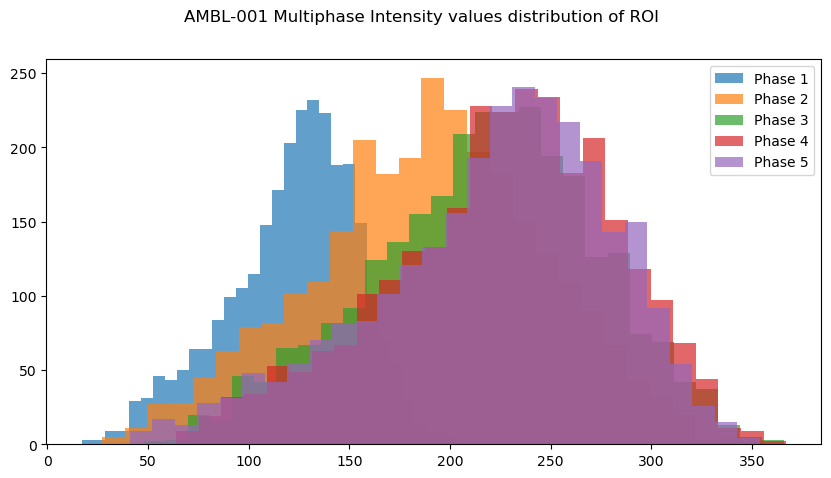

In [22]:
plt.figure(figsize=(10, 5))
plt.suptitle("AMBL-001 Multiphase Intensity values distribution of ROI")

#axes[0,0].imshow(v1[83, :, :], cmap=plt.cm.gray)
plt.hist(v1[roi == 1], bins=get_n_bins(v1[roi == 1]), label="Phase 1", alpha = 0.7)
plt.hist(v2[roi == 1], bins=get_n_bins(v2[roi == 1]), label="Phase 2", alpha = 0.7)
plt.hist(v3[roi == 1], bins=get_n_bins(v3[roi == 1]), label="Phase 3", alpha = 0.7)
plt.hist(v4[roi == 1], bins=get_n_bins(v4[roi == 1]), label="Phase 4", alpha = 0.7)
plt.hist(v5[roi == 1], bins=get_n_bins(v5[roi == 1]), label="Phase 5", alpha = 0.7)

plt.legend(loc='upper right')

# Display the plot
plt.show()

## Benign/Malign class

In [23]:
tumor_df = df[df["tumor/benign"] == 1]
benign_df = df[df["tumor/benign"] == 0]

### Histogram of intensity values

#### Region of interests

In [24]:
tumor_df.head(1)

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path,Registered AX Sen Vibrant MultiPhase path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...,/media/bendico765/Crucial X9/MRI Lesions/manif...


In [25]:
tumor_values = {
    "phase1": [],
    "phase2": [],
    "phase3": [],
    "phase4": [],
    "phase5": []
}

benign_values = {
    "phase1": [],
    "phase2": [],
    "phase3": [],
    "phase4": [],
    "phase5": []
}

# compute the tumor data
for _, row in tumor_df.iterrows():
    v1, v2, v3, v4, v5 = get_multiphase_mri(row["Registered AX Sen Vibrant MultiPhase path"]) # load the 5 mri volumes
    roi = np.load(row["Cleaned Roi mask Filepath"]) # load the region of interest

    for _ in v1[roi==1]:
        tumor_values["phase1"].append(_)

    for _ in v2[roi==1]:
        tumor_values["phase2"].append(_)

    for _ in v3[roi==1]:
        tumor_values["phase3"].append(_)

    for _ in v4[roi==1]:
        tumor_values["phase4"].append(_)

    for _ in v5[roi==1]:
        tumor_values["phase5"].append(_)
    
# compute the benign data
for _, row in benign_df.iterrows():
    v1, v2, v3, v4, v5 = get_multiphase_mri(row["Registered AX Sen Vibrant MultiPhase path"]) # load the 5 mri volumes
    roi = np.load(row["Cleaned Roi mask Filepath"]) # load the region of interest

    for _ in v1[roi==1]:
        benign_values["phase1"].append(_)

    for _ in v2[roi==1]:
        benign_values["phase2"].append(_)

    for _ in v3[roi==1]:
        benign_values["phase3"].append(_)

    for _ in v4[roi==1]:
        benign_values["phase4"].append(_)

    for _ in v5[roi==1]:
        benign_values["phase5"].append(_)

In [26]:
benign_metadata_df = pd.DataFrame(
    [
        [
            np.mean( benign_values[phase] ),
            np.median( benign_values[phase] ),
            np.std( benign_values[phase] )
        ]
        for phase in ["phase1", "phase2", "phase3", "phase4", "phase5"]
    ],
    index = ["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"],
    columns = ["Mean", "Median", "Std"]
)

In [27]:
benign_metadata_df

,Mean,Median,Std
Phase 1,123.954724,119.0,59.540543
Phase 2,201.501983,194.0,97.680068
Phase 3,232.444644,223.0,108.047119
Phase 4,251.443112,242.0,114.863811
Phase 5,262.927401,254.0,119.059264


In [28]:
tumor_metadata_df = pd.DataFrame(
    [
        [
            np.mean( tumor_values[phase] ),
            np.median( tumor_values[phase] ),
            np.std( tumor_values[phase] )
        ]
        for phase in ["phase1", "phase2", "phase3", "phase4", "phase5"]
    ],
    index = ["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"],
    columns = ["Mean", "Median", "Std"]
)

In [29]:
tumor_metadata_df

,Mean,Median,Std
Phase 1,130.251451,126.0,61.855722
Phase 2,249.480221,217.0,151.376192
Phase 3,274.373943,243.0,151.140468
Phase 4,282.722693,255.0,148.239878
Phase 5,285.803769,262.0,145.865080


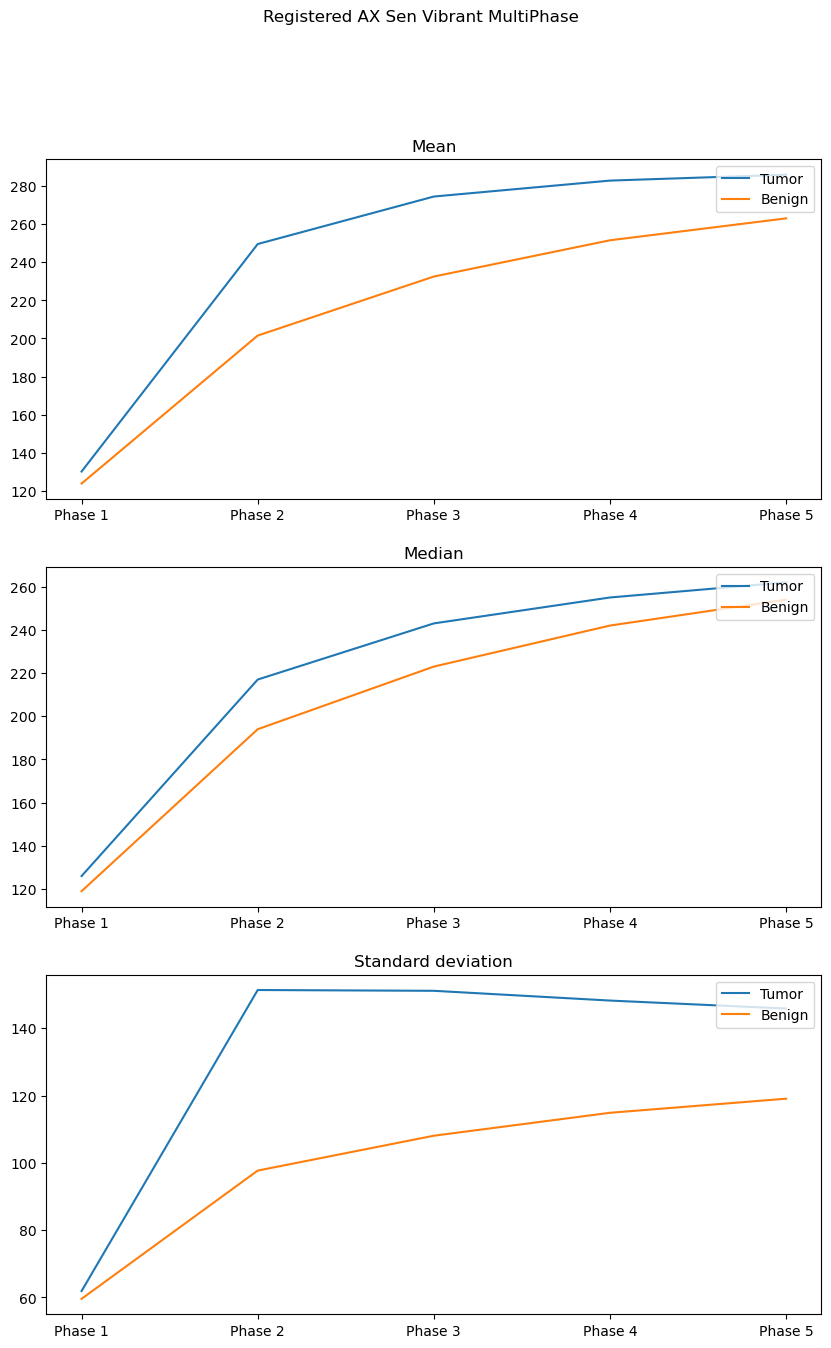

In [32]:
fig, axes = plt.subplots(3,1, figsize=(10,15))
fig.suptitle("Registered AX Sen Vibrant MultiPhase")

# mean plot
axes[0].plot(["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"], tumor_metadata_df["Mean"].values, label="Tumor")
axes[0].plot(["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"], benign_metadata_df["Mean"].values, label="Benign")
axes[0].set_title("Mean")
axes[0].legend(loc='upper right')

# median plot
axes[1].plot(["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"], tumor_metadata_df["Median"].values, label="Tumor")
axes[1].plot(["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"], benign_metadata_df["Median"].values, label="Benign")
axes[1].set_title("Median")
axes[1].legend(loc='upper right')

# std plot
axes[2].plot(["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"], tumor_metadata_df["Std"].values, label="Tumor")
axes[2].plot(["Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5"], benign_metadata_df["Std"].values, label="Benign")
axes[2].set_title("Standard deviation")
axes[2].legend(loc='upper right')

plt.savefig("/media/bendico765/Crucial X9/MRI Lesions/figures/multiphase_statistics.png")

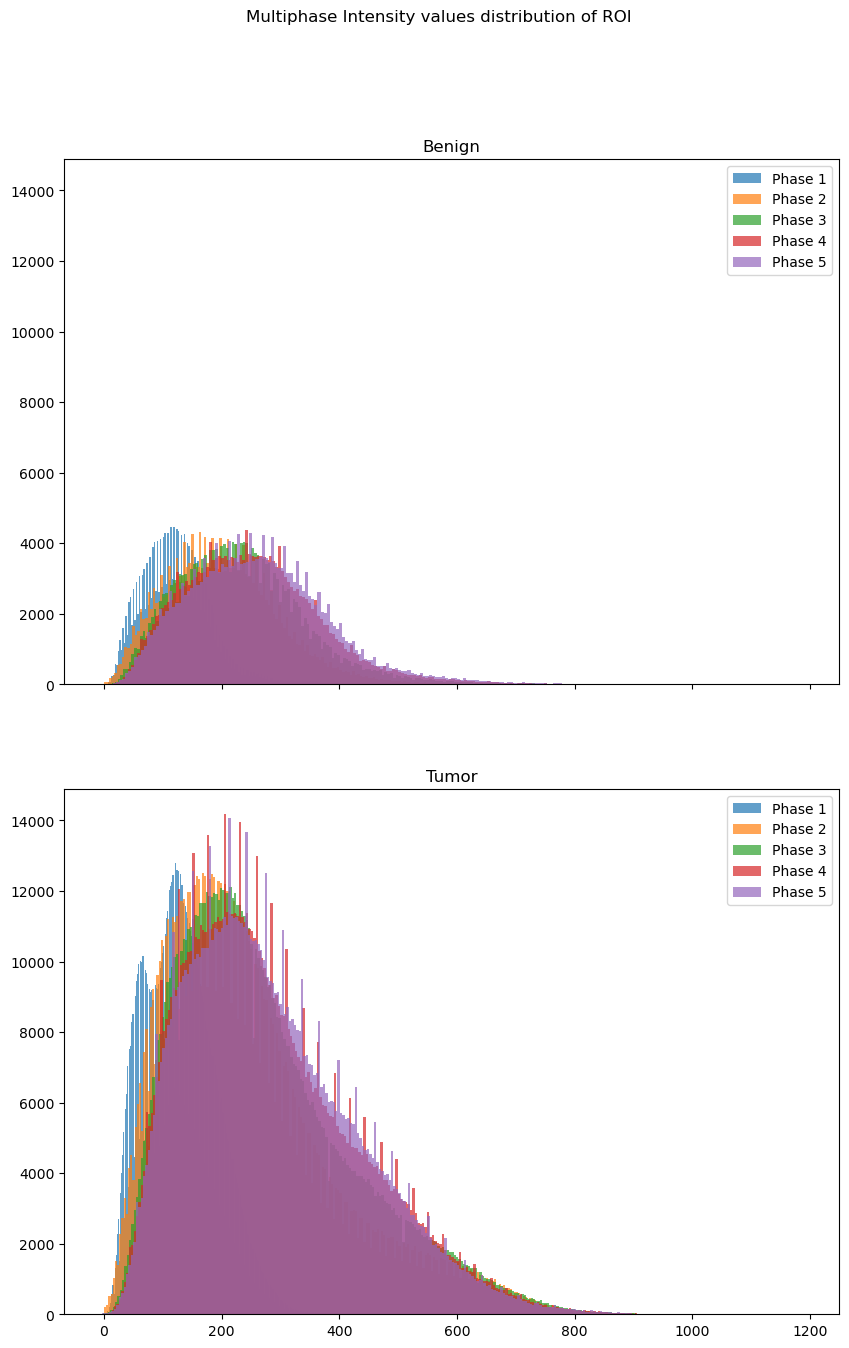

In [33]:
fig, axes = plt.subplots(2,1, figsize=(10,15), sharex=True, sharey=True)
fig.suptitle("Multiphase Intensity values distribution of ROI")

axes[0].hist(benign_values["phase1"], bins=get_n_bins(benign_values["phase1"]), label="Phase 1", alpha = 0.7)
axes[0].hist(benign_values["phase2"], bins=get_n_bins(benign_values["phase2"]), label="Phase 2", alpha = 0.7)
axes[0].hist(benign_values["phase3"], bins=get_n_bins(benign_values["phase3"]), label="Phase 3", alpha = 0.7)
axes[0].hist(benign_values["phase4"], bins=get_n_bins(benign_values["phase4"]), label="Phase 4", alpha = 0.7)
axes[0].hist(benign_values["phase5"], bins=get_n_bins(benign_values["phase5"]), label="Phase 5", alpha = 0.7)
axes[0].set_title("Benign")
axes[0].legend(loc='upper right')

axes[1].hist(tumor_values["phase1"], bins=get_n_bins(tumor_values["phase1"]), label="Phase 1", alpha = 0.7)
axes[1].hist(tumor_values["phase2"], bins=get_n_bins(tumor_values["phase2"]), label="Phase 2", alpha = 0.7)
axes[1].hist(tumor_values["phase3"], bins=get_n_bins(tumor_values["phase3"]), label="Phase 3", alpha = 0.7)
axes[1].hist(tumor_values["phase4"], bins=get_n_bins(tumor_values["phase4"]), label="Phase 4", alpha = 0.7)
axes[1].hist(tumor_values["phase5"], bins=get_n_bins(tumor_values["phase5"]), label="Phase 5", alpha = 0.7)
axes[1].set_title("Tumor")
axes[1].legend(loc='upper right')

# Display the plot
plt.savefig("/media/bendico765/Crucial X9/MRI Lesions/figures/multiphase_distributions.png")